In [2]:
# Predictive Modeling & Scenario Forecasting – Fleet Analytics

This notebook explores predictive modeling and scenario analysis techniques to identify high-cost incidents and evaluate potential cost-saving strategies in fleet operations.

1. **Predictors of High-Cost Incidents**  
   - Question: Can we build a simple model to predict which incidents (or drivers) will exceed a cost threshold?  
   - Data: All incident-level attributes from `service_type_df`, driver and vehicle features

2. Driver Risk Scoring :
    - Question: Can we assign a risk score to each driver based on historical behavior and usage patterns?


3. **Cost‑Saving Scenario Analysis**  
    - Question: What % cost savings could the business realize by, for example, rotating out vehicles older than X years or retraining drivers in the top risk quartile?  
   



In [38]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler



financial_data_df=pd.read_csv("../data/corporate_profit_and_loss_summary.csv")
driver_data_df=pd.read_csv('../data/drivers_data.csv')
vehicle_driver_assignment_df = pd.read_csv("../data/vehicle_driver_assignment.csv")
profit_vehicles_df = pd.read_csv("../data/profit_per_vehicle.csv")
vehicle_data_df = pd.read_csv("../data/vehicles_data.csv")
maintenance_cost = pd.read_csv("../data/material_usage_per_vehicle.csv")

service_type_df= pd.read_csv("../data/service_type.csv") 

vehicle_profit_df= pd.read_csv('../data/profit_per_vehicle.csv')

trip_logs_df = pd.read_csv("../data/trip_logs.csv")

vehicle_contract_data = pd.read_csv("../data/driver_payment.csv")

incident_model_data= pd.read_csv('../data/incident_model_data.csv')

In [39]:
# Convert datetime columns
trip_logs_df['start_date'] = pd.to_datetime(trip_logs_df['start_date'])
service_type_df['event_date'] = pd.to_datetime(service_type_df['event_date'])


In [40]:

# For each incident, aggregate telematics data for trips in prior 90 days
def agg_telematics_for_incidents(trip_logs, incidents, window_days=90):
    # Merge to associate each trip with incident date by vehicle_id
    merged = trip_logs.merge(
        incidents[['event_id', 'vehicle_id', 'event_date']], 
        on='vehicle_id', how='inner'
    )

    # Filter trips within the window before incident
    merged = merged[
        (merged['start_date'] <= merged['event_date']) & 
        (merged['start_date'] >= merged['event_date'] - pd.Timedelta(days=window_days))
    ]

    # Aggregate telematics features per incident
    agg = merged.groupby('event_id').agg(
        total_miles=('distance_miles', 'sum'),
        avg_speed=('avg_speed_mph', 'mean'),
        total_idle_time=('idle_time_min', 'sum'),
        harsh_brakes=('harsh_brake_count', 'sum'),
        trip_count=('trip_id', 'count')
    ).reset_index()

    return agg

# Call the function
telematics_agg = agg_telematics_for_incidents(trip_logs_df, service_type_df)

telematics_agg.columns

service_type_df = service_type_df.merge(telematics_agg, on='event_id', how='left')


telematic_cols = ['total_miles', 'avg_speed', 'total_idle_time', 'harsh_brakes', 'trip_count']
service_type_df[telematic_cols] = service_type_df[telematic_cols].fillna(0)

df= service_type_df.copy()


In [41]:
df.columns

Index(['event_id', 'vehicle_id', 'driver_id', 'event_date', 'service_type',
       'cost', 'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'total_miles', 'avg_speed', 'total_idle_time', 'harsh_brakes',
       'trip_count'],
      dtype='object')


## 1. **Predictors of High-Cost Incidents**  
   - Question: Can we build a simple model to predict which incidents (or drivers) will exceed a cost threshold?  
   - Data: All incident-level attributes from `service_type_df`, driver and vehicle features

In [42]:
##Define high-cost treshold and target 

threshold = df['cost'].quantile(0.75)

df['high_cost']=(df['cost']>threshold).astype(int)


df.columns

Index(['event_id', 'vehicle_id', 'driver_id', 'event_date', 'service_type',
       'cost', 'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'total_miles', 'avg_speed', 'total_idle_time', 'harsh_brakes',
       'trip_count', 'high_cost'],
      dtype='object')

In [ ]:
cols_to_drop = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
cols_to_drop = [
    'event_id', 'vehicle_id', 'driver_id', 'event_date',
    'service_type', 'cost', 'severity', 'downtime_hours', 'high_cost'  # only drop 'high_cost' from X, not y
]

X= df.drop(columns=cols_to_drop+['high_cost'])



In [47]:

y= df['high_cost']
X.columns


Index(['claim_type', 'vehicle_age', 'total_miles', 'avg_speed',
       'total_idle_time', 'harsh_brakes', 'trip_count'],
      dtype='object')

In [ ]:
# Drop duplicate telematics columns with suffixes
# Also drop any columns that will make it easy for the machine learning to predict cost 
# Drop columns ending with _x or _y and also drop specific unwanted columns




numeric_cols = ['downtime_hours', 'vehicle_age', 'total_miles', 'avg_speed', 
                'total_idle_time', 'harsh_brakes', 'trip_count']
cat_cols = ['claim_type', 'severity']

# One-hot encode categorical cols for correlation analysis
df_encoded = pd.concat([df[numeric_cols], 
                        pd.get_dummies(df[cat_cols], drop_first=True),
                        df['high_cost']], axis=1)

# Compute correlations with the target
corr_series = df_encoded.corr()['high_cost'].sort_values(ascending=False).reset_index()
corr_series.columns = ['feature', 'correlation_with_high_cost']


corr_series.head()






,feature,correlation_with_high_cost
0,high_cost,1.000000
1,downtime_hours,0.816941
2,avg_speed,0.086294
3,total_idle_time,-0.017043
4,total_miles,-0.022277


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

cat_cols = ['claim_type']
num_cols = ['vehicle_age', 'total_miles', 'avg_speed', 
            'total_idle_time', 'harsh_brakes', 'trip_count']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# Build a simple pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X, y)
##Keeps 20% of the data out for final evaluation, 
# ensures both train and test have the same proportion of high‑cost incidents.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['claim_type']),
                                                 ('num', 'passthrough',
                                                  ['vehicle_age', 'total_miles',
                                                   'avg_speed',
                                                   'total_idle_time',
                                                   'harsh_brakes',
                                                   'trip_count'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Baseline Model (logistic Regression)


In [54]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, roc_auc_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression model with balanced class weight
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        54
           1       0.31      0.56      0.40        18

    accuracy                           0.58        72
   macro avg       0.56      0.57      0.54        72
weighted avg       0.68      0.58      0.61        72

ROC AUC Score: 0.6327160493827161


The model predicts high-cost incidents (class 1) with a recall of 56%, so, it correctly identifies 56% of all actual high-cost cases. However, the precision for high-cost predictions is 31%, indicating that around 69% of the incidents flagged as high-cost are false positives

| Metric    | Low-Cost (0) | High-Cost (1) |
| --------- | ------------ | ------------- |
| Precision | 0.80         | 0.31          |
| Recall    | 0.59         | 0.56          |
| F1-Score  | 0.68         | 0.40          |
| Support   | 54           | 18            |


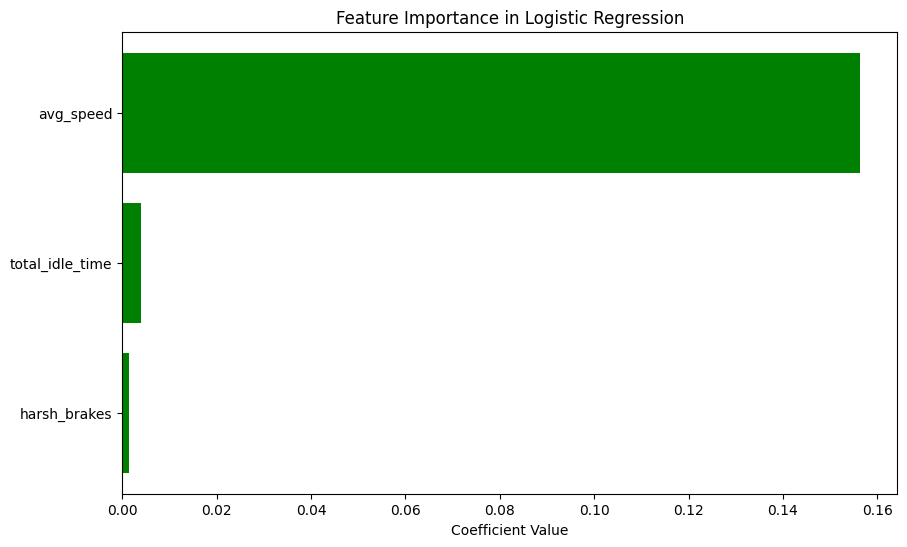

           feature  coefficient
3        avg_speed     0.156396
4  total_idle_time     0.003892
5     harsh_brakes     0.001355


In [58]:
# Get feature names after preprocessing (one-hot encoded claim_type + numeric)
cat_feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([cat_feature_names, num_cols])

# Get the coefficients from the Logistic Regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a sorted dataframe for plotting

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)


# Filter for positive coefficients (green bars)
positive_coefs = coef_df[coef_df['coefficient'] > 0]

# Sort by coefficient descending
positive_coefs = positive_coefs.sort_values(by='coefficient', ascending=False)

# Plot the top features by absolute coefficient value
plt.figure(figsize=(10,6))
colors = ['green' if c > 0 else 'red' for c in positive_coefs['coefficient']]
plt.barh(positive_coefs['feature'], positive_coefs['coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Highest impact on top
plt.show()



print(positive_coefs[['feature', 'coefficient']])


### Feature Importance in Logistic Regression Analysis

The logistic regression model highlights two main factors that predict high-cost incidents. First, higher average speeds are associated with an increased chance of costly incidents, suggesting that riskier driving behaviors like speeding play an important role in driving up costs. Second, more idle time also raises the predicted risk of expensive incidents, which could reflect inefficient vehicle usage that leads to higher operational expenses.